## Young People's Dataset Survey

### Initial Data Cleaning

Reads the responses.csv and splits it into X and target variable. The rows with "blanks" in target variables are dropped as it might not be a good idea to impute the target variable values.

After this, the data is concatenated again and goes through autocleaning which does data imputation of remaining missing values of feature set examples.

It is interesting to note that while Autoclean takes mean for continuous values like 'Height' to calculate the missing values, it uses mode for other categorical values like 'Entertainment spending'. This is what I was hoping to do so it fits perfectly.

Autoclean also makes sure all columns have numerical values. 

The data is split again into features and target variable examples.

In [1]:
from datacleaner import autoclean
import pandas as pd
from sklearn.utils import shuffle

data = pd.read_csv("responses.csv", sep=',')
data = shuffle(data)
data_X = data.drop('Empathy', axis=1)
data_Y = data['Empathy']
for i,nullbool in enumerate(data_Y.isnull()):
    if nullbool==True:
        data_Y = data_Y.drop(data.index[i])
        data_X = data_X.drop(data.index[i])
data_Y = data_Y.reset_index(drop=True)
data_X = data_X.reset_index(drop=True)
data = pd.concat([data_X, data_Y], axis=1)
autoclean(data, drop_nans=False, copy=False, ignore_update_check=False)
train_data = data[:-150]
test_data = data[-150:]
test_data_X = test_data.drop('Empathy', axis=1)
test_data_Y = test_data['Empathy']
data = train_data
data_Y = data['Empathy']
data_X = data.drop('Empathy', axis=1)




### One-hot encoding (Skip this)

We perform one-hot encoding to use it for classification models. Also, we do not do one-hot encoding for continuous features like Height, Weight etc. 
#### This isn't needed as the feature values are weighted and express various degrees.  (or they are continuous)

In [3]:
# import pandas as pd
# from dummyPy import OneHotEncoder

# # # Making all columns have numerical data - almost done - not required as autoclean solves problem

# # # unique_vals=[]
# # # for col in cols:
# # #     unique_vals.append(data[col].unique())

# # # for index, row in data.iterrows():
# # #     for col in cols:
# # #         print(col)
# # #         if row[col] in unique_vals[col] and row[col]!="" and row[col].isnull()!= True:
# # #             row[col]= unique_vals[col].index(row[col])

# # # One-hot encoding - Not required as feature values are expression of various degrees and are weighted.

# data_X_O = data_X.drop('Height', axis=1)
# data_X_O = data_X_O.drop('Weight', axis=1)
# data_X_O = data_X_O.drop('Age', axis=1)


# cols = list(data_X_O)

# encoder = OneHotEncoder(cols)
# encoder.fit(data_X_O)
# data_X_O = encoder.transform(data_X_O)
# Height = data_X['Height']
# Weight = data_X['Weight']
# Age = data_X['Age']
# data_X = pd.concat([data_X_O, Height, Weight, Age], axis=1)


### Normalization of Data

We perform feature normalization for all features.

In [2]:
from sklearn import preprocessing
df_X = pd.DataFrame()
cols = list(data_X)
for col in cols:
    print(col)
    column = data_X[[col]].values.astype(float)
    # Create a minimum and maximum processor object
    min_max_scaler = preprocessing.MinMaxScaler()
    
    # Create an object to transform the data to fit minmax processor
    column_scaled = min_max_scaler.fit_transform(column)
    # Run the normalizer on the dataframe
    df_X = pd.concat([df_X, pd.DataFrame(column_scaled, columns=data_X[[col]].columns)], axis=1)
data_X = df_X


Music
Slow songs or fast songs
Dance
Folk
Country
Classical music
Musical
Pop
Rock
Metal or Hardrock
Punk
Hiphop, Rap
Reggae, Ska
Swing, Jazz
Rock n roll
Alternative
Latino
Techno, Trance
Opera
Movies
Horror
Thriller
Comedy
Romantic
Sci-fi
War
Fantasy/Fairy tales
Animated
Documentary
Western
Action
History
Psychology
Politics
Mathematics
Physics
Internet
PC
Economy Management
Biology
Chemistry
Reading
Geography
Foreign languages
Medicine
Law
Cars
Art exhibitions
Religion
Countryside, outdoors
Dancing
Musical instruments
Writing
Passive sport
Active sport
Gardening
Celebrities
Shopping
Science and technology
Theatre
Fun with friends
Adrenaline sports
Pets
Flying
Storm
Darkness
Heights
Spiders
Snakes
Rats
Ageing
Dangerous dogs
Fear of public speaking
Smoking
Alcohol
Healthy eating
Daily events
Prioritising workload
Writing notes
Workaholism
Thinking ahead
Final judgement
Reliability
Keeping promises
Loss of interest
Friends versus money
Funniness
Fake
Criminal damage
Decision making
Elec

## Analyzing the target variable

We see from a seaborn plot of the distribution of target variable observation that the there is a severe representation problem withing the classes. Classes are increasingly represented as we move from 1 to 5.

c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


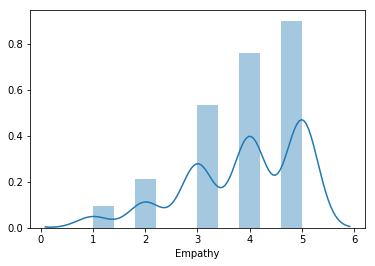

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(data_Y)
plt.show()

We use SMOTE to balance our imbalanced dataset by 'creating synthetic' new features for the under-represented class.

In [6]:
from imblearn.over_sampling import SMOTE
from imblearn.datasets import make_imbalance

cols = list(data_X.columns)
colsY = ['Empathy']

smote = SMOTE(kind = "borderline1", k_neighbors  = 10)
data_X_without_headers, data_Y_without_headers = smote.fit_sample(data_X, data_Y)

data_X_without_SMOTE = data_X
data_Y_without_SMOTE = data_Y

data_X =  pd.DataFrame(data_X_without_headers, columns=cols)
data_Y =  pd.DataFrame(data_Y_without_headers, columns=colsY)


Let's plot target variable distribution again.

c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


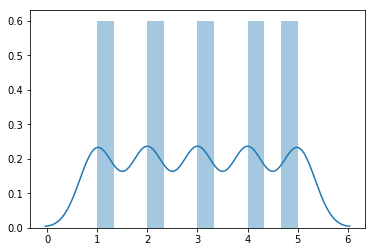

In [7]:
sns.distplot(data_Y)
plt.show()

## Analyzing the dataset

Let's have a look at the correlation matrix of the data set. With this visualization, we are able to determine which features have high correlation with each other (higher is worse) and the features that are highly correlated to the target variable (higher is better).

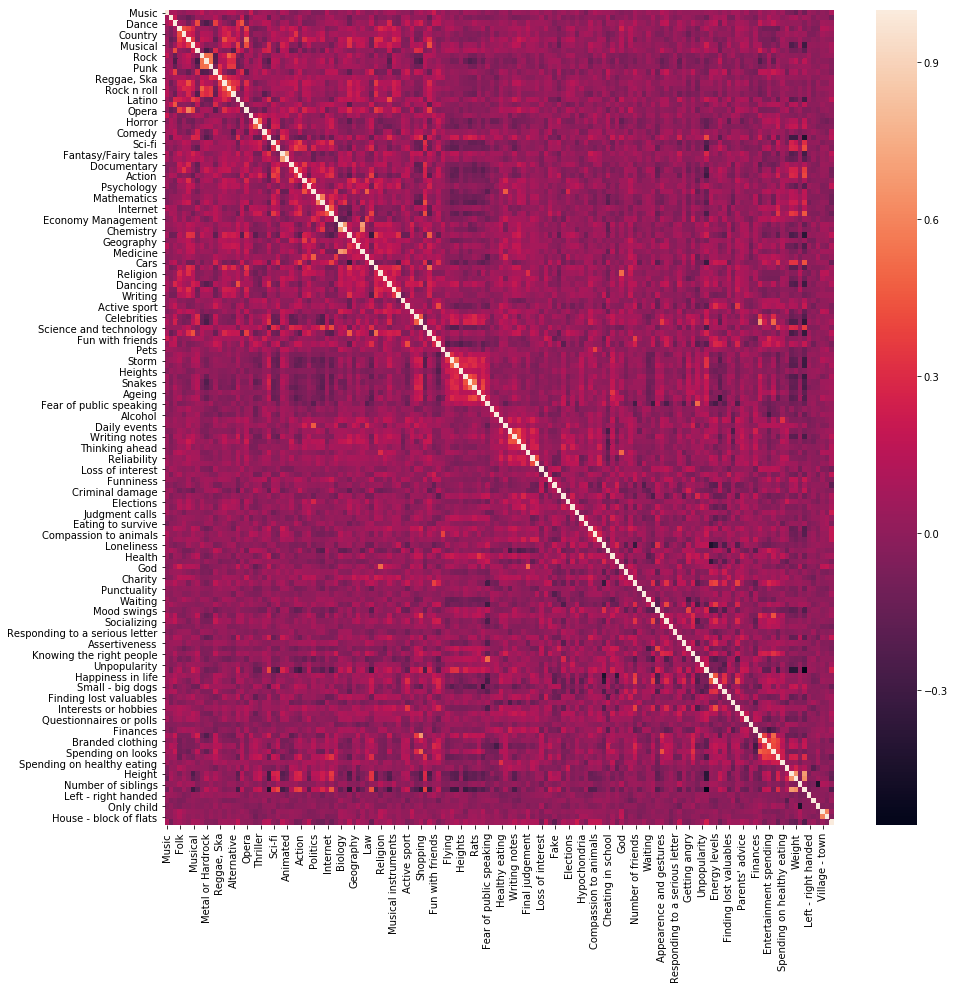

In [8]:
corr_mat = data.corr()
plt.subplots(figsize=(15,15))
sns.heatmap(corr_mat)
plt.show()


Let's use the data of the  correlation matrix to determine which features are possibly irrelevant. (correlation to target variable is lesser than 1%.

In [9]:
target_corr = corr_mat['Empathy'].sort_values(ascending=False)
possibly_irrelevant_features = [feature for feature,elem in target_corr.items() if elem<0.01 if elem >-0.01]
print(possibly_irrelevant_features)

['Punctuality', 'Movies', 'Classical music', 'Musical instruments', 'Responding to a serious letter', 'Chemistry', 'Opera', 'Entertainment spending', 'Pets', 'Waiting']


We can also print out those features that are highly correlated with each other: 60)

In [10]:
cols = list(data_X)
for col in cols:
    target_corr = corr_mat[col].sort_values(ascending=False)
    feature_most_correlated_with_own = [feature for feature,elem in target_corr.items() if elem>0.6 or elem <-0.6]
    if len(feature_most_correlated_with_own)>1:
        print("High Correlated features for ", col)
        print(feature_most_correlated_with_own[1:])

High Correlated features for  Fantasy/Fairy tales
['Animated']
High Correlated features for  Animated
['Fantasy/Fairy tales']
High Correlated features for  Biology
['Medicine', 'Chemistry']
High Correlated features for  Chemistry
['Biology', 'Medicine']
High Correlated features for  Medicine
['Biology', 'Chemistry']
High Correlated features for  Shopping
['Shopping centres']
High Correlated features for  Shopping centres
['Shopping']
High Correlated features for  Height
['Gender', 'Weight']
High Correlated features for  Weight
['Height', 'Gender']
High Correlated features for  Gender
['Height', 'Weight']
High Correlated features for  Village - town
['House - block of flats']
High Correlated features for  House - block of flats
['Village - town']


## Principal Componenet Analysis

PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction and engineering. 

The main goal of a PCA analysis is to identify patterns in data; PCA aims to detect the correlation between variables. If a strong correlation between variables exists, the attempt to reduce the dimensionality only makes sense. In a nutshell, this is what PCA is all about: Finding the directions of maximum variance in high-dimensional data and project it onto a smaller dimensional subspace while retaining most of the information.

##### Currently commented out as it seems to decrease accuracy even on test set.

In [4]:
# from sklearn.decomposition import PCA
# pca = PCA(0.95)
# pca.fit(data_X)
# print(pca.explained_variance_)
# pca.n_components_
# data_X_new = pca.transform(data_X)
# test_data_X_new = pca.transform(test_data_X)
# data_new = pd.concat([pd.DataFrame(data_X_new), pd.DataFrame(data_Y)], axis=1)

[1.12867375 0.8511446  0.56631215 0.42350994 0.38299328 0.3400272
 0.29204429 0.25749352 0.24299801 0.23517644 0.211875   0.20532574
 0.18289018 0.18053544 0.17698969 0.16280128 0.15797459 0.14524731
 0.14175399 0.13716944 0.13143111 0.12852955 0.12411887 0.12179004
 0.1168347  0.11251843 0.10890534 0.10706798 0.10213142 0.098969
 0.09836823 0.09413882 0.09373355 0.09207758 0.09140187 0.0860695
 0.08546997 0.08427576 0.08148739 0.08045716 0.07959938 0.07596093
 0.07359656 0.072645   0.0708788  0.06971275 0.06914138 0.06714955
 0.06539608 0.0637488  0.06358883 0.06300482 0.06278374 0.06082859
 0.05950044 0.05816881 0.05679281 0.0557888  0.05551041 0.05400098
 0.05272638 0.05157693 0.05101933 0.05078443 0.05044991 0.04915916
 0.04872772 0.04789553 0.0474154  0.04653479 0.04504644 0.0448867
 0.04395858 0.04291309 0.04189893 0.04172616 0.04171585 0.04092836
 0.03980842 0.03937068 0.03863722 0.03840286 0.03741871 0.03683966
 0.03643088 0.03578792 0.0353849  0.03473242 0.0343595  0.03344218


### Plot the correlation matrix again

We plot the correlation matrix again after running PCA to understand new distrubution and to  visualize feature reduction. Also replot the new features that are irrelevant and those that can be still highly correlated with each other

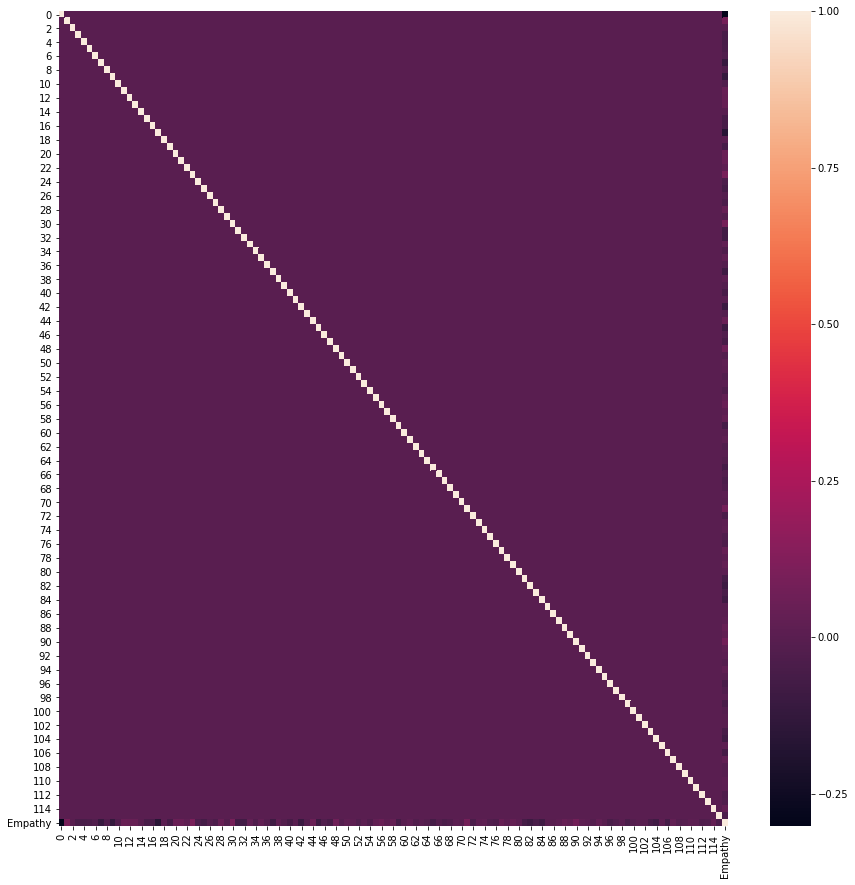

[87, 105, 57, 78, 73, 53, 18, 80, 92, 111, 69, 98, 63, 41, 95, 86, 70, 60, 2, 102, 14, 85, 101]


In [167]:
corr_mat = data_new.corr()
plt.subplots(figsize=(15,15))
sns.heatmap(corr_mat)
plt.show()
target_corr = corr_mat['Empathy'].sort_values(ascending=False)
possibly_irrelevant_features = [feature for feature,elem in target_corr.items() if elem<0.01 if elem >-0.01]
print(possibly_irrelevant_features)

In [174]:
cols = list(data_X_new)
for feature,elem in corr_mat.items():
    target_corr = corr_mat[feature].sort_values(ascending=False)
    feature_most_correlated_with_own = [feature for feature,elem in target_corr.items() if elem>0.7 or elem <-0.7]
    if len(feature_most_correlated_with_own)>1:
        print("High Correlated features for ", feature)
        print(feature_most_correlated_with_own[1:])

## Model Evaluation

The below funcion calculates accuracy scores, F-score, Precision and Recall after employing K-Fold Cross Validation. 

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
import numpy as np

def get_cv_metrics(text_clf, train_data, train_class, k_split):
    accuracy_scores = cross_val_score(text_clf,  # steps to convert raw messages      into models
                                      train_data,  # training data
                                      train_class,  # training labels
                                      cv=k_split,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                                      scoring='accuracy',  # which scoring metric?
                                      n_jobs=-1,  # -1 = use all cores = faster
                                      )
    cv_predicted = cross_val_predict(text_clf,
                                     train_data,
                                     train_class,
                                     cv=k_split)

    return np.mean(accuracy_scores), classification_report(train_class, cv_predicted)

## Learning Models

### SGD

#### Tuning

Let us tune the hyperparameters using Grid Search cross-validation.

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

def tune_SGD():
    clf = linear_model.SGDClassifier()
    parameters = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron',],
                  'penalty': ['l2','l1','elasticnet'],
                  'max_iter': [1000000,10000, 100, 10],
                  'tol': [1e-2,1e-3,1e-4],
                  'alpha': [1e-3, 1e-4,1e-2]}
    gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
    gs_clf = gs_clf.fit(data_X, data_Y)
    print(gs_clf.best_score_)
    for param_name in sorted(parameters.keys()):
        print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))
tune_SGD()

0.6411575562700965
alpha: 0.0001
loss: 'hinge'
max_iter: 10000
penalty: 'l1'
tol: 0.0001


#### Training

We will now train the model using parameters from above tuning that gave best score.

In [16]:
from sklearn.externals import joblib
from sklearn import linear_model
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score

def train_SGD():
    
    '''TRAINING'''

    clf = linear_model.SGDClassifier(loss='hinge', penalty='l1',alpha=1e-4, random_state=16,max_iter=10000, tol=0.0001, shuffle=True)    
    clf = RFECV(clf, step=1, cv=5, n_jobs=-1).fit(data_X,data_Y.values.ravel())
    joblib.dump(clf, 'SGD_model.pkl')

    
    """PERFORMANCE EVALUATION"""
    accuracy, clf_report = get_cv_metrics(clf, data_X, data_Y.values.ravel(), k_split=10)
    print("Accuracy: ", accuracy)
    print(clf_report)
    return clf
    
model = train_SGD()

Accuracy:  0.639375
             precision    recall  f1-score   support

        1.0       0.88      0.93      0.91       320
        2.0       0.80      0.80      0.80       320
        3.0       0.54      0.54      0.54       320
        4.0       0.45      0.46      0.46       320
        5.0       0.51      0.46      0.48       320

avg / total       0.64      0.64      0.64      1600



## Naive Bayes

### Multinomial Naive Bayes

#### Tuning

Let us tune the hyperparameters using Grid Search cross-validation.

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV


def tune_MultinomialNB():
    clf = MultinomialNB()
    parameters = {'alpha': np.arange(0.0, 2.0, 0.1), 'fit_prior':[True, False], 'class_prior':[None]}
    gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
    gs_clf = gs_clf.fit(data_X, data_Y)
    print(gs_clf.best_score_)
    for param_name in sorted(parameters.keys()):
        print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))
tune_MultinomialNB()

0.526875
alpha: 1.4000000000000001
class_prior: None
fit_prior: True


c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Training

We can now train the Multinomial NB using the hyperparameters from GridSearch's best results. 

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFECV
from sklearn.externals import joblib


def train_MultinomialNB():
    '''TRAINING'''

    clf = MultinomialNB(alpha=1.8, fit_prior=True, class_prior=None)
    clf = RFECV(clf, step=1, cv=5, n_jobs=-1).fit(data_X,data_Y.values.ravel())

    joblib.dump(clf, 'Multinomial_nb_model.pkl')

    """PERFORMANCE EVALUATION"""
    accuracy, clf_report = get_cv_metrics(clf, data_X, data_Y.values.ravel(), k_split=10)
    print("Accuracy: ", accuracy)
    print(clf_report)
    return clf

model = train_MultinomialNB()

Accuracy:  0.5331250000000001
             precision    recall  f1-score   support

        1.0       0.93      0.83      0.87       320
        2.0       0.55      0.73      0.63       320
        3.0       0.46      0.31      0.37       320
        4.0       0.36      0.19      0.25       320
        5.0       0.39      0.61      0.47       320

avg / total       0.54      0.53      0.52      1600



### Bernoulli Navie Bayes
#### Tuning

Let us tune the hyperparameter of BernoulliNB using Grid Search cross-validation.

In [37]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV


def tune_BernoulliNB():
    clf = BernoulliNB()
    parameters = {'alpha': np.arange(0.0, 2.0, 0.1), 'fit_prior':[True, False], 'class_prior':[None]}
    gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
    gs_clf = gs_clf.fit(data_X, data_Y)
    print(gs_clf.best_score_)
    for param_name in sorted(parameters.keys()):
        print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))
tune_BernoulliNB()

0.44630225080385855
alpha: 1.4000000000000001
class_prior: None
fit_prior: True


#### Training

We can now train the Bernoulli NB using the hyperparameters from GridSearch's best results. 

In [17]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

def train_BernoulliNB():
    '''TRAINING'''

    clf = BernoulliNB(alpha=1.4, fit_prior=True, class_prior=None)
    clf = RFECV(clf, step=1, cv=5, n_jobs=-1).fit(data_X,data_Y.values.ravel())
    joblib.dump(clf, 'Bernoulli_nb_model.pkl')

    """PERFORMANCE EVALUATION"""
    accuracy, clf_report = get_cv_metrics(clf, data_X, data_Y.values.ravel(), k_split=10)
    print("Accuracy: ", accuracy)
    print(clf_report)
    return clf

model = train_BernoulliNB()

Accuracy:  0.48312499999999997
             precision    recall  f1-score   support

        1.0       0.86      0.78      0.81       320
        2.0       0.44      0.67      0.53       320
        3.0       0.35      0.21      0.26       320
        4.0       0.33      0.19      0.24       320
        5.0       0.41      0.57      0.48       320

avg / total       0.48      0.48      0.47      1600



### Random forest
#### Tuning

Let us tune the hyperparameters of Random Forest using Grid Search cross-validation.

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def tune_RF():
    clf = RandomForestClassifier()
    parameters = {'n_estimators': np.arange(50, 800, 50), 'max_depth':np.arange(50, 500, 50)}
    gs_clf = GridSearchCV(clf, parameters, n_jobs=7)
    gs_clf = gs_clf.fit(data_X, data_Y)
    print(gs_clf.best_score_)
    for param_name in sorted(parameters.keys()):
        print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))
tune_RF()

0.7440514469453376
max_depth: 300
n_estimators: 700


#### Training

We can now train the Random Forest Classifer using the hyperparameters from GridSearch's best results. 

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib


def train_RF():
    '''TRAINING'''
    clf = RandomForestClassifier(n_estimators = 700, max_depth=300, random_state=16, n_jobs = -1)
    clf = clf.fit(data_X,data_Y.values.ravel())
#     clf = RFECV(clf, step=1, cv=5, n_jobs=-1).fit(data_X,data_Y) ## Comment above line if you want to uncomment this one
    joblib.dump(clf, 'RF_model.pkl')
    """PERFORMANCE EVALUATION"""
    accuracy, clf_report = get_cv_metrics(clf, data_X, data_Y.values.ravel(), k_split=10)
    print("Accuracy: ", accuracy)
    print(clf_report)
    return clf

model = train_RF()

Accuracy:  0.78125
             precision    recall  f1-score   support

        1.0       1.00      0.93      0.96       320
        2.0       0.96      0.91      0.93       320
        3.0       0.83      0.71      0.76       320
        4.0       0.69      0.61      0.64       320
        5.0       0.55      0.76      0.63       320

avg / total       0.80      0.78      0.79      1600



### ExtraTree Classifier
#### Tuning

Let us tune the hyperparameters of Extra Tree Classifier using Grid Search cross-validation.

In [39]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

def tune_ET():
    clf = ExtraTreesClassifier()
    parameters = {'n_estimators': np.arange(50, 800, 50), 'max_depth':np.arange(50, 500, 50)}
    gs_clf = GridSearchCV(clf, parameters, n_jobs=7)
    gs_clf = gs_clf.fit(data_X, data_Y)
    print(gs_clf.best_score_)
    for param_name in sorted(parameters.keys()):
        print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))
tune_ET()

0.7672025723472669
max_depth: 150
n_estimators: 700


#### Training

We can now train the Extra Tree Classifier using the hyperparameters from GridSearch's best results. 

In [15]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.externals import joblib

def train_ET():
    '''TRAINING'''
    clf = ExtraTreesClassifier(n_estimators = 700, max_depth=150, random_state=16, n_jobs = -1).fit(data_X,data_Y.values.ravel())
#     clf = RFECV(clf, step=1, cv=5, n_jobs=-1).fit(data_X,data_Y)
    joblib.dump(clf, 'ET_model.pkl')

    """PERFORMANCE EVALUATION"""
    accuracy, clf_report = get_cv_metrics(clf, data_X, data_Y.values.ravel(), k_split=10)
    print("Accuracy: ", accuracy)
    print(clf_report)
train_ET()

Accuracy:  0.7840215053763441
             precision    recall  f1-score   support

        1.0       1.00      0.96      0.98       308
        2.0       0.95      0.94      0.94       308
        3.0       0.83      0.75      0.78       308
        4.0       0.59      0.55      0.57       308
        5.0       0.59      0.72      0.65       308

avg / total       0.79      0.78      0.79      1540



### SVC
#### Tuning

Let us tune the hyperparameters of Support Vector Classifier using Grid Search cross-validation.

###### Note: Since, there are lots of hyper parameters for SVC. We tune each kernel separately. Some of the hyperparameters are kernel specific like degree (only for poly) and coef0 (only for poly and sigmoid). We tune these parameters separately for each of those kernels, in the interest of saving time. 

In [41]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import numpy as np
def tune_SVC():
    clf = SVC()
    
#     0.7466237942122187
# C: 0.1
# coef0: 0.0
# degree: 4
# gamma: 0.7000000000000001
# kernel: 'poly'
# tol: 0.1

    
#     'rbf','poly','sigmoid'
# 'degree':np.arange(2, 5, 1),
# 'coef0':np.arange(0.0, 1.0, 0.1),
    parameters = {'C': np.arange(0.1, 5, 0.5), 'kernel':['rbf'], 'coef0':np.arange(0.0, 1.0, 0.1), 'gamma': np.arange(0, 1.0, 0.1),'tol': [1e-1,1e-2,1e-3,1e-4]}
    gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
    gs_clf = gs_clf.fit(data_X, data_Y)
    print(gs_clf.best_score_)
    for param_name in sorted(parameters.keys()):
        print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))
tune_SVC()

0.7781350482315113
C: 3.1
coef0: 0.0
gamma: 0.1
kernel: 'rbf'
tol: 0.1


#### Training

We can now train the Support Vector Classifier using the hyperparameters from GridSearch's best results. 

In [16]:
from sklearn.svm import SVC
from sklearn.externals import joblib
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score

def train_SVM():
    '''TRAINING'''
    clf = SVC(C = 3.1, kernel='rbf', gamma = 0.1, tol = 1e-1).fit(data_X,data_Y.values.ravel())
#     clf = RFECV(clf, step=1, cv=5, n_jobs=-1).fit(data_X,data_Y)
    joblib.dump(clf, 'SVC_model.pkl')

    """PERFORMANCE EVALUATION"""
    accuracy, clf_report = get_cv_metrics(clf, data_X, data_Y.values.ravel(), k_split=10)
    print("Accuracy: ", accuracy)
    print(clf_report)
train_SVM()

Accuracy:  0.7858924731182795
             precision    recall  f1-score   support

        1.0       1.00      0.96      0.98       308
        2.0       0.98      0.94      0.96       308
        3.0       0.78      0.77      0.78       308
        4.0       0.60      0.57      0.59       308
        5.0       0.60      0.68      0.64       308

avg / total       0.79      0.79      0.79      1540



### Logistic Regression
#### Tuning

Let us tune the hyperparameters of Logistic Regression Classifier using Grid Search cross-validation.

###### Note: Since, there are lots of hyper parameters for LR. We tune each solver separately. Some of the hyperparameters are kernel specific like penalty (only l2 for 'newton-cg', 'lbfgs' and 'sag'), dual (only with l2 for liblinear), max_iter, multi_class etc. We tune these parameters separately for each of those solvers and parameters, in the interest of saving time. 

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np

# 0.4228855721393035
# C: 0.1
# dual: True
# fit_intercept: True
# intercept_scaling: 1.7999999999999998
# n_jobs: -1
# penalty: 'l2'
# solver: 'liblinear'
# tol: 0.1

# 0.42686567164179107
# C: 3.6
# class_weight: None
# fit_intercept: False
# intercept_scaling: 1.9999999999999998
# multi_class: 'ovr'
# n_jobs: -1
# penalty: 'l1'
# solver: 'saga'
# tol: 0.1

# 'newton-cg', 'lbfgs',
# 'max_iter': np.arange(50, 1000, 50)
# multi_class : str, {‘ovr’, ‘multinomial’}, default: ‘ovr’
#         ['newton-cg', 'lbfgs', 'sag', 'saga']
        
def tune_LR():
    clf = LogisticRegression()
    parameters = {'C': np.arange(0.1, 4, 0.5), 'penalty':['l2'], 'max_iter': np.arange(50, 500, 50),'class_weight': [None, 'balanced'], 'multi_class': ['ovr','multinomial'], 'intercept_scaling':np.arange(1.4, 2.4, 0.2), 'solver':['sag'], 'fit_intercept': [True,False],'tol': [1e-1,1e-2,1e-3,1e-4],'n_jobs':[-1]}
    gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
    gs_clf = gs_clf.fit(data_X, data_Y)
    print(gs_clf.best_score_)
    for param_name in sorted(parameters.keys()):
        print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))
tune_LR()

0.6572347266881029
C: 2.6
class_weight: None
fit_intercept: True
intercept_scaling: 1.4
max_iter: 300
multi_class: 'ovr'
n_jobs: -1
penalty: 'l2'
solver: 'saga'
tol: 0.0001


c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


#### Training

We can now train the Logistic Regression Classifier using the hyperparameters from GridSearch's best results. 

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from sklearn.feature_selection import RFECV
from sklearn.externals import joblib

def train_LR():
    '''TRAINING'''
    clf = LogisticRegression(C = 2.6, dual=False, penalty = 'l2', tol = 1e-4, solver = 'saga', n_jobs = -1, multi_class = 'ovr', fit_intercept = True, intercept_scaling = 1.4).fit(data_X,data_Y.values.ravel())
#     clf = RFECV(clf, step=1, cv=5, n_jobs=-1).fit(data_X,data_Y.values.ravel())
    joblib.dump(clf, 'LR_model.pkl')

    """PERFORMANCE EVALUATION"""
    accuracy, clf_report = get_cv_metrics(clf, data_X, data_Y.values.ravel(), k_split=10)
    print("Accuracy: ", accuracy)
    print(clf_report)
train_LR()

c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\u

Accuracy:  0.6385161290322581
             precision    recall  f1-score   support

        1.0       0.90      0.95      0.92       308
        2.0       0.73      0.88      0.80       308
        3.0       0.54      0.55      0.54       308
        4.0       0.42      0.34      0.37       308
        5.0       0.52      0.48      0.50       308

avg / total       0.62      0.64      0.63      1540



c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import KFold
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib


# encode class values as integers
encoder = LabelEncoder()
encoder.fit(data_Y)
encoded_Y = encoder.transform(data_Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

def save_model(model):
    # saving model
    json_model = model.to_json()
    open('model_architecture.json', 'w').write(json_model)
    # saving weights
    model.save_weights('model_weights.h5', overwrite=True)

# define baseline model
def nn_model():
    # create model
    model = Sequential()
    model.add(Dense(70, input_dim=149, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


encoder.fit(test_data_Y)
encoded_t_Y = encoder.transform(test_data_Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_t_y = np_utils.to_categorical(encoded_t_Y)


estimator = nn_model()
# KerasClassifier(build_fn=nn_model, epochs=100, batch_size=512, verbose=0)
estimator.fit(data_X, dummy_y, epochs=100, batch_size=512, verbose=0)
save_model(estimator)

#Model Evaluation
# """PERFORMANCE EVALUATION"""
# seed = 7
# np.random.seed(seed)
# kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
# results = cross_val_score(estimator, data_X, dummy_y, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))



c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Stacking using stacked generalizer.

#### **Avoid this as it throws an error right now. Will fix this issue down the line.

This ensemble technique allows us to stack models using multiple blending models, combining them in a non-linear manner.


In [37]:
from sklearn.linear_model import LogisticRegression
from stacked_generalizer import StackedGeneralizer
from sklearn.externals import joblib


def train_stack():
    base_models = [joblib.load('SGD_model.pkl')]
    blending_model = LogisticRegression(random_state=607)
    
    # initialize multi-stage model
    sg = StackedGeneralizer(base_models, blending_model, n_folds=10, verbose=True)
    sg.fit(data_X, data_Y)
    #     joblib.dump(sg, 'Stacked_model.pkl')
    """PERFORMANCE EVALUATION"""
    accuracy, clf_report = get_cv_metrics(sg, data_X, data_Y, k_split=10)
    print("Accuracy: ", accuracy)
    
train_stack()

Fitting Base Models...
Fitting model 01: RFECV(cv=5,
   estimator=SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=10000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=16, shuffle=True,
       tol=0.01, verbose=0, warm_start=False),
   n_jobs=-1, scoring=None, step=1, verbose=0)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
Fitting Blending Model:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=607, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...on36\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\runpy.py in _run_code(code=<code object <module> at 0x000001BCE66874B0, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'c:\users\administrator\appdata\local\programs\py...ges\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'c:\users\administrator\appdata\local\programs\py...\python36\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...on36\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'c:\\users\\a...36\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...on36\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x000001BCE66874B0, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'c:\users\administrator\appdata\local\programs\py...ges\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'c:\users\administrator\appdata\local\programs\py...\python36\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...on36\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'c:\\users\\a...36\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\tornado\platform\asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    122         except (RuntimeError, AssertionError):
    123             old_loop = None
    124         try:
    125             self._setup_logging()
    126             asyncio.set_event_loop(self.asyncio_loop)
--> 127             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Win...EventLoop running=True closed=False debug=False>>
    128         finally:
    129             asyncio.set_event_loop(old_loop)
    130 
    131     def stop(self):

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\asyncio\base_events.py in run_forever(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
    417             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    418                                    finalizer=self._asyncgen_finalizer_hook)
    419         try:
    420             events._set_running_loop(self)
    421             while True:
--> 422                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_Windo...EventLoop running=True closed=False debug=False>>
    423                 if self._stopping:
    424                     break
    425         finally:
    426             self._stopping = False

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\asyncio\base_events.py in _run_once(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
   1427                         logger.warning('Executing %s took %.3f seconds',
   1428                                        _format_handle(handle), dt)
   1429                 finally:
   1430                     self._current_handle = None
   1431             else:
-> 1432                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(908, 1)>>
   1433         handle = None  # Needed to break cycles when an exception occurs.
   1434 
   1435     def _set_coroutine_wrapper(self, enabled):
   1436         try:

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\asyncio\events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(908, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (908, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\tornado\platform\asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=908, events=1)
    112             self.writers.remove(fd)
    113         del self.handlers[fd]
    114 
    115     def _handle_events(self, fd, events):
    116         fileobj, handler_func = self.handlers[fd]
--> 117         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    118 
    119     def start(self):
    120         try:
    121             old_loop = asyncio.get_event_loop()

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 5, 4, 0, 9, 59, 264686, tzinfo=tzutc()), 'msg_id': '134b63d89bdb47edbd69a9b1bc626ca2', 'msg_type': 'execute_request', 'session': '6d94ab4a185349c889cc59578c4b780a', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '134b63d89bdb47edbd69a9b1bc626ca2', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'6d94ab4a185349c889cc59578c4b780a']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 5, 4, 0, 9, 59, 264686, tzinfo=tzutc()), 'msg_id': '134b63d89bdb47edbd69a9b1bc626ca2', 'msg_type': 'execute_request', 'session': '6d94ab4a185349c889cc59578c4b780a', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '134b63d89bdb47edbd69a9b1bc626ca2', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'6d94ab4a185349c889cc59578c4b780a'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 5, 4, 0, 9, 59, 264686, tzinfo=tzutc()), 'msg_id': '134b63d89bdb47edbd69a9b1bc626ca2', 'msg_type': 'execute_request', 'session': '6d94ab4a185349c889cc59578c4b780a', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '134b63d89bdb47edbd69a9b1bc626ca2', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = 'from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.FunctionDef object>, <_ast.Expr object>], cell_name='<ipython-input-37-7889eb214899>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1bca43b60f0, executio...rue silent=False shell_futures=True> result=None>)
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])
   2908                 code = compiler(mod, cell_name, "single")
-> 2909                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x000001BCA43EAD20, file "<ipython-input-37-7889eb214899>", line 18>
        result = <ExecutionResult object at 1bca43b60f0, executio...rue silent=False shell_futures=True> result=None>
   2910                     return True
   2911 
   2912             # Flush softspace
   2913             if softspace(sys.stdout, 0):

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x000001BCA43EAD20, file "<ipython-input-37-7889eb214899>", line 18>, result=<ExecutionResult object at 1bca43b60f0, executio...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x000001BCA43EAD20, file "<ipython-input-37-7889eb214899>", line 18>
        self.user_global_ns = {'BernoulliNB': <class 'sklearn.naive_bayes.BernoulliNB'>, 'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'In': ['', "from datacleaner import autoclean\nimport pandas ...['Empathy']\ndata_X = data.drop('Empathy', axis=1)", 'from sklearn import preprocessing\ndf_X = pd.Data...ns=data_X[[col]].columns)], axis=1)\ndata_X = df_X', 'from sklearn.model_selection import cross_val_sc... classification_report(train_class, cv_predicted)', 'from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()', 'from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()', 'from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()', 'from sklearn.model_selection import cross_val_sc... classification_report(train_class, cv_predicted)', 'from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()', 'from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()', "from datacleaner import autoclean\nimport pandas ...['Empathy']\ndata_X = data.drop('Empathy', axis=1)", 'from sklearn.model_selection import cross_val_sc... classification_report(train_class, cv_predicted)', 'from sklearn.externals import joblib\nfrom sklear..._data_Y, pred_Y))\n#Accuracy:  0.02666666666666667', 'from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()', 'from sklearn.model_selection import cross_val_sc... classification_report(train_class, cv_predicted)', 'from sklearn.externals import joblib\nfrom sklear..._data_Y, pred_Y))\n#Accuracy:  0.02666666666666667', 'from sklearn.externals import joblib\nfrom sklear..._data_Y, pred_Y))\n#Accuracy:  0.02666666666666667', 'from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()', 'from imblearn.over_sampling import SMOTE\nfrom im...data_X, data_Y = smote.fit_sample(data_X, data_Y)', 'sns.distplot(data_Y)\nplt.show()', ...], 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'Out': {34:         0
0     5.0
1     4.0
2     2.0
3     2.... 1.0
1588  1.0
1589  1.0

[1590 rows x 1 columns]}, 'RFECV': <class 'sklearn.feature_selection.rfe.RFECV'>, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'SMOTE': <class 'imblearn.over_sampling.smote.SMOTE'>, 'StackedGeneralizer': <class 'stacked_generalizer.StackedGeneralizer'>, ...}
        self.user_ns = {'BernoulliNB': <class 'sklearn.naive_bayes.BernoulliNB'>, 'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'In': ['', "from datacleaner import autoclean\nimport pandas ...['Empathy']\ndata_X = data.drop('Empathy', axis=1)", 'from sklearn import preprocessing\ndf_X = pd.Data...ns=data_X[[col]].columns)], axis=1)\ndata_X = df_X', 'from sklearn.model_selection import cross_val_sc... classification_report(train_class, cv_predicted)', 'from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()', 'from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()', 'from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()', 'from sklearn.model_selection import cross_val_sc... classification_report(train_class, cv_predicted)', 'from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()', 'from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()', "from datacleaner import autoclean\nimport pandas ...['Empathy']\ndata_X = data.drop('Empathy', axis=1)", 'from sklearn.model_selection import cross_val_sc... classification_report(train_class, cv_predicted)', 'from sklearn.externals import joblib\nfrom sklear..._data_Y, pred_Y))\n#Accuracy:  0.02666666666666667', 'from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()', 'from sklearn.model_selection import cross_val_sc... classification_report(train_class, cv_predicted)', 'from sklearn.externals import joblib\nfrom sklear..._data_Y, pred_Y))\n#Accuracy:  0.02666666666666667', 'from sklearn.externals import joblib\nfrom sklear..._data_Y, pred_Y))\n#Accuracy:  0.02666666666666667', 'from sklearn.linear_model import LogisticRegress... print("Accuracy: ", accuracy)\n    \ntrain_stack()', 'from imblearn.over_sampling import SMOTE\nfrom im...data_X, data_Y = smote.fit_sample(data_X, data_Y)', 'sns.distplot(data_Y)\nplt.show()', ...], 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'Out': {34:         0
0     5.0
1     4.0
2     2.0
3     2.... 1.0
1588  1.0
1589  1.0

[1590 rows x 1 columns]}, 'RFECV': <class 'sklearn.feature_selection.rfe.RFECV'>, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'SMOTE': <class 'imblearn.over_sampling.smote.SMOTE'>, 'StackedGeneralizer': <class 'stacked_generalizer.StackedGeneralizer'>, ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
D:\IML-Project-6\young-people-survey\<ipython-input-37-7889eb214899> in <module>()
     13     #     joblib.dump(sg, 'Stacked_model.pkl')
     14     """PERFORMANCE EVALUATION"""
     15     accuracy, clf_report = get_cv_metrics(sg, data_X, data_Y, k_split=10)
     16     print("Accuracy: ", accuracy)
     17     
---> 18 train_stack()

...........................................................................
D:\IML-Project-6\young-people-survey\<ipython-input-37-7889eb214899> in train_stack()
     10     # initialize multi-stage model
     11     sg = StackedGeneralizer(base_models, blending_model, n_folds=10, verbose=True)
     12     sg.fit(data_X, data_Y)
     13     #     joblib.dump(sg, 'Stacked_model.pkl')
     14     """PERFORMANCE EVALUATION"""
---> 15     accuracy, clf_report = get_cv_metrics(sg, data_X, data_Y, k_split=10)
     16     print("Accuracy: ", accuracy)
     17     
     18 train_stack()

...........................................................................
D:\IML-Project-6\young-people-survey\<ipython-input-14-bfd08ca3b983> in get_cv_metrics(text_clf=StackedGeneralizer(base_models=[RFECV(cv=5,
   e...start=False),
          n_folds=10, verbose=True), train_data=array([[5.        , 3.        , 2.        , ...,....., 0.        , 0.        ,
        0.        ]]), train_class=array([5., 4., 2., ..., 1., 1., 1.]), k_split=10)
      7     accuracy_scores = cross_val_score(text_clf,  # steps to convert raw messages      into models
      8                                       train_data,  # training data
      9                                       train_class,  # training labels
     10                                       cv=k_split,  # split data randomly into 10 parts: 9 for training, 1 for scoring
     11                                       scoring='accuracy',  # which scoring metric?
---> 12                                       n_jobs=-1,  # -1 = use all cores = faster
     13                                       )
     14     cv_predicted = cross_val_predict(text_clf,
     15                                      train_data,
     16                                      train_class,

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py in cross_val_score(estimator=StackedGeneralizer(base_models=[RFECV(cv=5,
   e...start=False),
          n_folds=10, verbose=True), X=array([[5.        , 3.        , 2.        , ...,....., 0.        , 0.        ,
        0.        ]]), y=array([5., 4., 2., ..., 1., 1., 1.]), groups=None, scoring='accuracy', cv=10, n_jobs=-1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
    337     cv_results = cross_validate(estimator=estimator, X=X, y=y, groups=groups,
    338                                 scoring={'score': scorer}, cv=cv,
    339                                 return_train_score=False,
    340                                 n_jobs=n_jobs, verbose=verbose,
    341                                 fit_params=fit_params,
--> 342                                 pre_dispatch=pre_dispatch)
        pre_dispatch = '2*n_jobs'
    343     return cv_results['test_score']
    344 
    345 
    346 def _fit_and_score(estimator, X, y, scorer, train, test, verbose,

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py in cross_validate(estimator=StackedGeneralizer(base_models=[RFECV(cv=5,
   e...start=False),
          n_folds=10, verbose=True), X=array([[5.        , 3.        , 2.        , ...,....., 0.        , 0.        ,
        0.        ]]), y=array([5., 4., 2., ..., 1., 1., 1.]), groups=None, scoring={'score': make_scorer(accuracy_score)}, cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False), n_jobs=-1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', return_train_score=False)
    201     scores = parallel(
    202         delayed(_fit_and_score)(
    203             clone(estimator), X, y, scorers, train, test, verbose, None,
    204             fit_params, return_train_score=return_train_score,
    205             return_times=True)
--> 206         for train, test in cv.split(X, y, groups))
        cv.split = <bound method StratifiedKFold.split of Stratifie...d(n_splits=10, random_state=None, shuffle=False)>
        X = array([[5.        , 3.        , 2.        , ...,....., 0.        , 0.        ,
        0.        ]])
        y = array([5., 4., 2., ..., 1., 1., 1.])
        groups = None
    207 
    208     if return_train_score:
    209         train_scores, test_scores, fit_times, score_times = zip(*scores)
    210         train_scores = _aggregate_score_dicts(train_scores)

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object cross_validate.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Thu May  3 19:17:00 2018
PID: 27240Python 3.6.5: c:\users\administrator\appdata\local\programs\python\python36\python.exe
...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (StackedGeneralizer(base_models=[RFECV(cv=5,
   e...start=False),
          n_folds=10, verbose=True), memmap([[5.        , 3.        , 2.        , ......., 0.        , 0.        ,
         0.        ]]), array([5., 4., 2., ..., 1., 1., 1.]), {'score': make_scorer(accuracy_score)}, array([  95,   98,   99, ..., 1587, 1588, 1589]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 557, 614, 619, 682,
       725, 759, 765, 784]), 0, None, None), {'return_times': True, 'return_train_score': False})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (StackedGeneralizer(base_models=[RFECV(cv=5,
   e...start=False),
          n_folds=10, verbose=True), memmap([[5.        , 3.        , 2.        , ......., 0.        , 0.        ,
         0.        ]]), array([5., 4., 2., ..., 1., 1., 1.]), {'score': make_scorer(accuracy_score)}, array([  95,   98,   99, ..., 1587, 1588, 1589]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 557, 614, 619, 682,
       725, 759, 765, 784]), 0, None, None)
        kwargs = {'return_times': True, 'return_train_score': False}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=StackedGeneralizer(base_models=[RFECV(cv=5,
   e...start=False),
          n_folds=10, verbose=True), X=memmap([[5.        , 3.        , 2.        , ......., 0.        , 0.        ,
         0.        ]]), y=array([5., 4., 2., ..., 1., 1., 1.]), scorer={'score': make_scorer(accuracy_score)}, train=array([  95,   98,   99, ..., 1587, 1588, 1589]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 557, 614, 619, 682,
       725, 759, 765, 784]), verbose=0, parameters=None, fit_params={}, return_train_score=False, return_parameters=False, return_n_test_samples=False, return_times=True, error_score='raise')
    483                              " make sure that it has been spelled correctly.)")
    484 
    485     else:
    486         fit_time = time.time() - start_time
    487         # _score will return dict if is_multimetric is True
--> 488         test_scores = _score(estimator, X_test, y_test, scorer, is_multimetric)
        test_scores = {}
        estimator = StackedGeneralizer(base_models=[RFECV(cv=5,
   e...start=False),
          n_folds=10, verbose=True)
        X_test = memmap([[5., 3., 2., ..., 0., 0., 0.],
        [... 1., 1.],
        [5., 4., 2., ..., 1., 0., 1.]])
        y_test = array([5., 4., 2., 2., 3., 4., 4., 1., 4., 4., 2..., 2., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])
        scorer = {'score': make_scorer(accuracy_score)}
        is_multimetric = True
    489         score_time = time.time() - start_time - fit_time
    490         if return_train_score:
    491             train_scores = _score(estimator, X_train, y_train, scorer,
    492                                   is_multimetric)

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py in _score(estimator=StackedGeneralizer(base_models=[RFECV(cv=5,
   e...start=False),
          n_folds=10, verbose=True), X_test=memmap([[5., 3., 2., ..., 0., 0., 0.],
        [... 1., 1.],
        [5., 4., 2., ..., 1., 0., 1.]]), y_test=array([5., 4., 2., 2., 3., 4., 4., 1., 4., 4., 2..., 2., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.]), scorer={'score': make_scorer(accuracy_score)}, is_multimetric=True)
    518 
    519     Will return a single float if is_multimetric is False and a dict of floats,
    520     if is_multimetric is True
    521     """
    522     if is_multimetric:
--> 523         return _multimetric_score(estimator, X_test, y_test, scorer)
        estimator = StackedGeneralizer(base_models=[RFECV(cv=5,
   e...start=False),
          n_folds=10, verbose=True)
        X_test = memmap([[5., 3., 2., ..., 0., 0., 0.],
        [... 1., 1.],
        [5., 4., 2., ..., 1., 0., 1.]])
        y_test = array([5., 4., 2., 2., 3., 4., 4., 1., 4., 4., 2..., 2., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])
        scorer = {'score': make_scorer(accuracy_score)}
    524     else:
    525         if y_test is None:
    526             score = scorer(estimator, X_test)
    527         else:

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py in _multimetric_score(estimator=StackedGeneralizer(base_models=[RFECV(cv=5,
   e...start=False),
          n_folds=10, verbose=True), X_test=memmap([[5., 3., 2., ..., 0., 0., 0.],
        [... 1., 1.],
        [5., 4., 2., ..., 1., 0., 1.]]), y_test=array([5., 4., 2., 2., 3., 4., 4., 1., 4., 4., 2..., 2., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.]), scorers={'score': make_scorer(accuracy_score)})
    548 
    549     for name, scorer in scorers.items():
    550         if y_test is None:
    551             score = scorer(estimator, X_test)
    552         else:
--> 553             score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = make_scorer(accuracy_score)
        estimator = StackedGeneralizer(base_models=[RFECV(cv=5,
   e...start=False),
          n_folds=10, verbose=True)
        X_test = memmap([[5., 3., 2., ..., 0., 0., 0.],
        [... 1., 1.],
        [5., 4., 2., ..., 1., 0., 1.]])
        y_test = array([5., 4., 2., 2., 3., 4., 4., 1., 4., 4., 2..., 2., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])
    554 
    555         if hasattr(score, 'item'):
    556             try:
    557                 # e.g. unwrap memmapped scalars

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\scorer.py in __call__(self=make_scorer(accuracy_score), estimator=StackedGeneralizer(base_models=[RFECV(cv=5,
   e...start=False),
          n_folds=10, verbose=True), X=memmap([[5., 3., 2., ..., 0., 0., 0.],
        [... 1., 1.],
        [5., 4., 2., ..., 1., 0., 1.]]), y_true=array([5., 4., 2., 2., 3., 4., 4., 1., 4., 4., 2..., 2., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.]), sample_weight=None)
    103             return self._sign * self._score_func(y_true, y_pred,
    104                                                  sample_weight=sample_weight,
    105                                                  **self._kwargs)
    106         else:
    107             return self._sign * self._score_func(y_true, y_pred,
--> 108                                                  **self._kwargs)
        self._kwargs = {}
    109 
    110 
    111 class _ProbaScorer(_BaseScorer):
    112     def __call__(self, clf, X, y, sample_weight=None):

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py in accuracy_score(y_true=array([5., 4., 2., 2., 3., 4., 4., 1., 4., 4., 2..., 2., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.]), y_pred=array([[3.30446921e-06, 7.38916159e-03, 2.051867...43e-03, 2.51947265e-03,
        1.43614632e-04]]), normalize=True, sample_weight=None)
    171     >>> accuracy_score(np.array([[0, 1], [1, 1]]), np.ones((2, 2)))
    172     0.5
    173     """
    174 
    175     # Compute accuracy for each possible representation
--> 176     y_type, y_true, y_pred = _check_targets(y_true, y_pred)
        y_type = undefined
        y_true = array([5., 4., 2., 2., 3., 4., 4., 1., 4., 4., 2..., 2., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])
        y_pred = array([[3.30446921e-06, 7.38916159e-03, 2.051867...43e-03, 2.51947265e-03,
        1.43614632e-04]])
    177     if y_type.startswith('multilabel'):
    178         differing_labels = count_nonzero(y_true - y_pred, axis=1)
    179         score = differing_labels == 0
    180     else:

...........................................................................
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py in _check_targets(y_true=array([5., 4., 2., 2., 3., 4., 4., 1., 4., 4., 2..., 2., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.]), y_pred=array([[3.30446921e-06, 7.38916159e-03, 2.051867...43e-03, 2.51947265e-03,
        1.43614632e-04]]))
     76     if y_type == set(["binary", "multiclass"]):
     77         y_type = set(["multiclass"])
     78 
     79     if len(y_type) > 1:
     80         raise ValueError("Classification metrics can't handle a mix of {0} "
---> 81                          "and {1} targets".format(type_true, type_pred))
        type_true = 'multiclass'
        type_pred = 'continuous-multioutput'
     82 
     83     # We can't have more than one value on y_type => The set is no more needed
     84     y_type = y_type.pop()
     85 

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets
___________________________________________________________________________

In [32]:
from sklearn.ensemble import VotingClassifier
from sklearn.externals import joblib

def train_VotingClassifier():
    """TRAINING"""

    clf1 = joblib.load('SGD_model.pkl')
    clf2 = joblib.load('SVC_model.pkl')
    clf3 = joblib.load('RF_model.pkl')
#     clf4 = joblib.load('Bernoulli_nb_model.pkl')
#     clf5 = joblib.load('Multinomial_nb_model.pkl')
    clf6 = joblib.load('LR_model.pkl')
    clf7 = joblib.load('ET_model.pkl')

    eclf1 = VotingClassifier(estimators=[('SGD', clf1),('SVC', clf2), ('RF', clf3), ('ET', clf7)], voting='hard')
    eclf1.fit(data_X, data_Y)
    joblib.dump(eclf1, 'Voting_model.pkl')
    """PERFORMANCE EVALUATION"""
    accuracy, clf_report = get_cv_metrics(eclf1, data_X, data_Y, k_split=10)
    print("Accuracy: ", accuracy) #Accuracy: 73.06
    print(clf_report)
    return eclf1
train_VotingClassifier()

c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn

c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  0.7846666666666666
             precision    recall  f1-score   support

        1.0       1.00      0.96      0.98       308
        2.0       0.94      0.94      0.94       308
        3.0       0.80      0.76      0.78       308
        4.0       0.59      0.58      0.58       308
        5.0       0.62      0.68      0.65       308

avg / total       0.79      0.78      0.79      1540



c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


VotingClassifier(estimators=[('SGD', RFECV(cv=5,
   estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=10000, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_st...timators=700, n_jobs=-1,
           oob_score=False, random_state=16, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

## Accuracy against Test set

Now, due to oversampling and CV metrics, the accuracy scores above are not very meaningful. Here, we have a look at how we perform against the test set. We can tune SMOTE to try and prevent overfitting in the future. Also, the validation set shouldn't have SMOTE performed on it (which was means we need to separate validation from training to get accurate results).

We have also normalized test_data_X to resemble our train data set distribution post-processing.

In [33]:
from sklearn.externals import joblib
from keras.models import Sequential, model_from_json

from sklearn import preprocessing
df_X = pd.DataFrame()
cols = list(test_data_X)
for col in cols:
    print(col)
    column = test_data_X[[col]].values.astype(float)
    # Create a minimum and maximum processor object
    min_max_scaler = preprocessing.MinMaxScaler()
    
    # Create an object to transform the data to fit minmax processor
    column_scaled = min_max_scaler.fit_transform(column)
    # Run the normalizer on the dataframe
    df_X = pd.concat([df_X, pd.DataFrame(column_scaled, columns=test_data_X[[col]].columns)], axis=1)
test_data_X = df_X



def load_model():
    # loading model
    model = model_from_json(open('model_architecture.json').read())
    model.load_weights('model_weights.h5')
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model


clf1 = joblib.load('SGD_model.pkl')
pred_y = clf1.predict(test_data_X)
print("Test accuracy for Stochastic Gradient Descent Classifier: ", accuracy_score(pred_y, test_data_Y))

clf2 = joblib.load('SVC_model.pkl')
pred_y = clf2.predict(test_data_X)
print("Test accuracy for Support Vector Classifier: ", accuracy_score(pred_y, test_data_Y))

clf3 = joblib.load('RF_model.pkl')
pred_y = clf3.predict(test_data_X)
print("Test accuracy for Random Forest: ", accuracy_score(pred_y, test_data_Y))

clf4 = joblib.load('Bernoulli_nb_model.pkl')
pred_y = clf4.predict(test_data_X)
print("Test accuracy for Bernoulli Naive Bayes: ", accuracy_score(pred_y, test_data_Y))

clf5 = joblib.load('Multinomial_nb_model.pkl')
pred_y = clf5.predict(test_data_X)
print("Test accuracy for Multinomial Naive Bayes: ", accuracy_score(pred_y, test_data_Y))

clf6 = joblib.load('LR_model.pkl')
pred_y = clf6.predict(test_data_X)
print("Test accuracy for Logistic Regression: ", accuracy_score(pred_y, test_data_Y))

clf7 = joblib.load('ET_model.pkl')
pred_y = clf7.predict(test_data_X)
print("Test accuracy for Extra Tree Classifier: ", accuracy_score(pred_y, test_data_Y))

clf8 = joblib.load('Voting_model.pkl')
pred_y = clf8.predict(test_data_X)
print("Test accuracy for Voting Classifier: ", accuracy_score(pred_y, test_data_Y))

#neural Network model
model = load_model()
# predictions
pred_y = model.predict_classes(test_data_X)
print("Test accuracy for Neural Networks: ", accuracy_score(pred_y, test_data_Y))



Music
Slow songs or fast songs
Dance
Folk
Country
Classical music
Musical
Pop
Rock
Metal or Hardrock
Punk
Hiphop, Rap
Reggae, Ska
Swing, Jazz
Rock n roll
Alternative
Latino
Techno, Trance
Opera
Movies
Horror
Thriller
Comedy
Romantic
Sci-fi
War
Fantasy/Fairy tales
Animated
Documentary
Western
Action
History
Psychology
Politics
Mathematics
Physics
Internet
PC
Economy Management
Biology
Chemistry
Reading
Geography
Foreign languages
Medicine
Law
Cars
Art exhibitions
Religion
Countryside, outdoors
Dancing
Musical instruments
Writing
Passive sport
Active sport
Gardening
Celebrities
Shopping
Science and technology
Theatre
Fun with friends
Adrenaline sports
Pets
Flying
Storm
Darkness
Heights
Spiders
Snakes
Rats
Ageing
Dangerous dogs
Fear of public speaking
Smoking
Alcohol
Healthy eating
Daily events
Prioritising workload
Writing notes
Workaholism
Thinking ahead
Final judgement
Reliability
Keeping promises
Loss of interest
Friends versus money
Funniness
Fake
Criminal damage
Decision making
Elec

c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The best model was SGD which produced the  accuracy of 0.6333333333333333.

## Analyze the errors
Let's analyze the errors in one of the top performing classifers:  Random Forest

In [34]:
clf3 = joblib.load('SGD_model.pkl')
pred_y = clf3.predict(test_data_X)
for true, pred in zip(pred_y, test_data_Y):
    if pred != true:
        print(test_data_X.iloc[[index]],pred,true)

   Music  Slow songs or fast songs  Dance  Folk  Country  Classical music  \
0    0.5                       0.5   0.75   0.5      0.0              0.5   

   Musical   Pop  Rock  Metal or Hardrock           ...                 Age  \
0      0.5  0.25   0.5               0.25           ...            0.428571   

     Height    Weight  Number of siblings  Gender  Left - right handed  \
0  0.354167  0.333333                 0.6     1.0                  1.0   

   Education  Only child  Village - town  House - block of flats  
0        0.0         0.0             0.0                     0.0  

[1 rows x 149 columns] 3.0 4.0
   Music  Slow songs or fast songs  Dance  Folk  Country  Classical music  \
0    0.5                       0.5   0.75   0.5      0.0              0.5   

   Musical   Pop  Rock  Metal or Hardrock           ...                 Age  \
0      0.5  0.25   0.5               0.25           ...            0.428571   

     Height    Weight  Number of siblings  Gender  Left -

   Music  Slow songs or fast songs  Dance  Folk  Country  Classical music  \
0    0.5                       0.5   0.75   0.5      0.0              0.5   

   Musical   Pop  Rock  Metal or Hardrock           ...                 Age  \
0      0.5  0.25   0.5               0.25           ...            0.428571   

     Height    Weight  Number of siblings  Gender  Left - right handed  \
0  0.354167  0.333333                 0.6     1.0                  1.0   

   Education  Only child  Village - town  House - block of flats  
0        0.0         0.0             0.0                     0.0  

[1 rows x 149 columns] 4.0 5.0
   Music  Slow songs or fast songs  Dance  Folk  Country  Classical music  \
0    0.5                       0.5   0.75   0.5      0.0              0.5   

   Musical   Pop  Rock  Metal or Hardrock           ...                 Age  \
0      0.5  0.25   0.5               0.25           ...            0.428571   

     Height    Weight  Number of siblings  Gender  Left -

   Music  Slow songs or fast songs  Dance  Folk  Country  Classical music  \
0    0.5                       0.5   0.75   0.5      0.0              0.5   

   Musical   Pop  Rock  Metal or Hardrock           ...                 Age  \
0      0.5  0.25   0.5               0.25           ...            0.428571   

     Height    Weight  Number of siblings  Gender  Left - right handed  \
0  0.354167  0.333333                 0.6     1.0                  1.0   

   Education  Only child  Village - town  House - block of flats  
0        0.0         0.0             0.0                     0.0  

[1 rows x 149 columns] 5.0 4.0
   Music  Slow songs or fast songs  Dance  Folk  Country  Classical music  \
0    0.5                       0.5   0.75   0.5      0.0              0.5   

   Musical   Pop  Rock  Metal or Hardrock           ...                 Age  \
0      0.5  0.25   0.5               0.25           ...            0.428571   

     Height    Weight  Number of siblings  Gender  Left -